In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
import zipfile
from shutil import copyfile

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2020-09-09 14:24:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.72.32, 2600:1409:12:2af::e59, 2600:1409:12:285::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.60.72.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   267MB/s    in 2.9s    

2020-09-09 14:24:48 (267 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
local_zip = '/tmp/cats-and-dogs.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
  zip_ref.extractall('/tmp')
  zip_ref.close()

In [4]:
try:
  os.mkdir('/tmp/cats-and-dogs')
  os.mkdir('/tmp/cats-and-dogs/training')
  os.mkdir('/tmp/cats-and-dogs/testing')
  os.mkdir('/tmp/cats-and-dogs/training/cats')
  os.mkdir('/tmp/cats-and-dogs/training/dogs')
  os.mkdir('/tmp/cats-and-dogs/testing/cats')
  os.mkdir('/tmp/cats-and-dogs/testing/dogs')
except OSError:
  pass

In [5]:
def split_data(Source, Training, Testing, Split_size):
  files = []
  for filename in os.listdir(Source):
    file  = Source + filename
    if os.path.getsize(file)>0:
      files.append(filename)
    else:
      print("{} is of zero length, so ignoring...".format(filename))

  training_length = int(len(files)*split_size)
  testing_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0:training_length]
  testing_set = shuffled_set[-testing_length:]

  for filename in training_set:
    this_file = Source + filename
    destination = Training + filename
    copyfile(this_file, destination)

  for filename in testing_set:
    this_file = Source + filename
    destination = Testing + filename
    copyfile(this_file, destination)

CATS_SOURCE_DIR = '/tmp/PetImages/Cat/'
CATS_TRAINING_DIR = '/tmp/cats-and-dogs/training/cats/'
CATS_TESTING_DIR = '/tmp/cats-and-dogs/testing/cats/'
DOGS_SOURCE_DIR = '/tmp/PetImages/Dog/'
DOGS_TRAINING_DIR = '/tmp/cats-and-dogs/training/dogs'
DOGS_TESTING_DIR = '/tmp/cats-and-dogs/testing/dogs'

split_size = 0.9
split_data(CATS_SOURCE_DIR, CATS_TRAINING_DIR, CATS_TESTING_DIR, split_size)
split_data(DOGS_SOURCE_DIR, DOGS_TRAINING_DIR, DOGS_TESTING_DIR, split_size)

666.jpg is of zero length, so ignoring...
11702.jpg is of zero length, so ignoring...


In [6]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                      shear_range = 0.2,
                                      horizontal_flip = True)
train_generator = train_datagen.flow_from_directory('/tmp/cats-and-dogs/training/',
                                                    target_size = (150,150),
                                                    batch_size = 64,
                                                    class_mode = 'binary')
test_datagen = ImageDataGenerator(rescale=1/255)
validation_gen = test_datagen.flow_from_directory('/tmp/cats-and-dogs/testing/',
                                                  target_size = (150,150),
                                                  batch_size = 32,
                                                  class_mode = 'binary')

Found 12499 images belonging to 2 classes.
Found 10140 images belonging to 2 classes.


In [7]:
model = tf.keras.models.Sequential([keras.layers.Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(64, (3,3), activation='relu'),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Conv2D(32, (3,3), activation='relu'),
                                    keras.layers.MaxPooling2D(pool_size=(2,2)),
                                    keras.layers.Flatten(),
                                    keras.layers.Dense(units = 512, activation='relu'),
                                    keras.layers.Dense(1, activation='sigmoid')])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0

In [9]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [10]:
class my_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs ={}):
    if logs.get('accuracy')>0.99:
      print('\nTraining accuracy reached 99%, stopping training..')
      self.model.stop_training = True

In [11]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = 10,
                    epochs = 15,
                    verbose = 1,
                    callbacks = [my_callback()],
                    validation_data = validation_gen)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
10/10 [==============================] - 34s 3s/step - loss: 0.0675 - accuracy: 0.9891 - val_loss: 2.3219e-08 - val_accuracy: 1.0000
Epoch 2/15
10/10 [==============================] - ETA: 0s - loss: 1.1533e-08 - accuracy: 1.0000
Training accuracy reached 99%, stopping training..
10/10 [==============================] - 33s 3s/step - loss: 1.1533e-08 - accuracy: 1.0000 - val_loss: 2.3083e-08 - val_accuracy: 1.0000


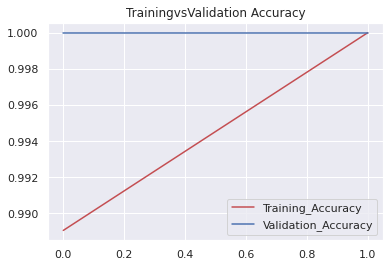

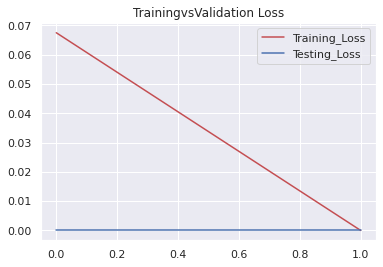

In [12]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label = 'Training_Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Validation_Accuracy')
plt.title('TrainingvsValidation Accuracy')
plt.legend()
plt.show()
plt.plot(epochs, loss, 'r', label = 'Training_Loss')
plt.plot(epochs, validation_loss, 'b', label = 'Testing_Loss')
plt.title('TrainingvsValidation Loss')
plt.legend()
plt.show()